In [12]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [13]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


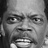

In [14]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg")
sample_image

In [15]:
np.array(sample_image).shape


(48, 48)

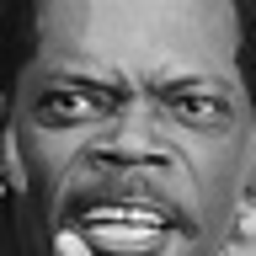

In [16]:
sample_image = sample_image.resize([256,256])
sample_image

In [17]:
np.array(sample_image).shape


(256, 256)

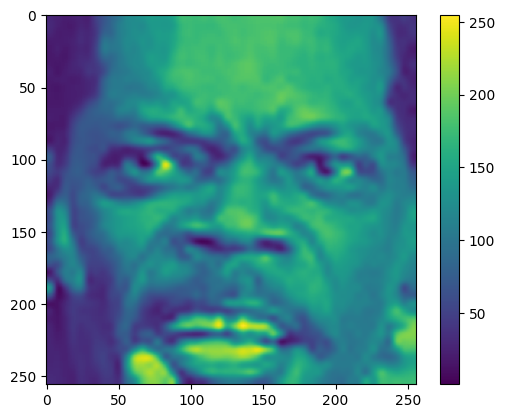

In [18]:
plt.imshow(np.array(sample_image))
plt.colorbar()

# Extract only face from images


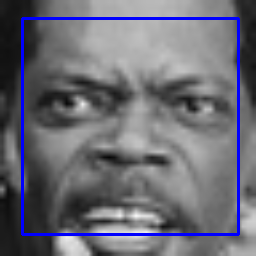

In [19]:
from google.colab.patches import cv2_imshow
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/My Drive/Train_Relabeled_Cleaned/angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)


In [20]:
cropped_img.shape

(256, 256, 3)

In [21]:
cropped_img = cropped_img.sum(axis=2)

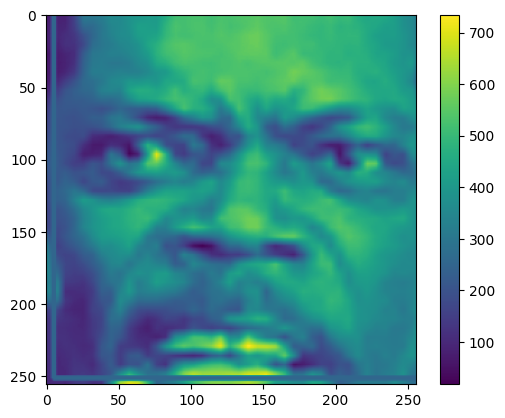

In [22]:
plt.imshow(cropped_img)
plt.colorbar()

# Load Data and Extract only Face


In [23]:
import cv2

In [24]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [25]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

In [26]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'bad', 'surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train_Relabeled_Cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [27]:
# x_data

In [28]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(18280, 200, 200, 1) (18280, 7)
(4570, 200, 200, 1) (4570, 7)


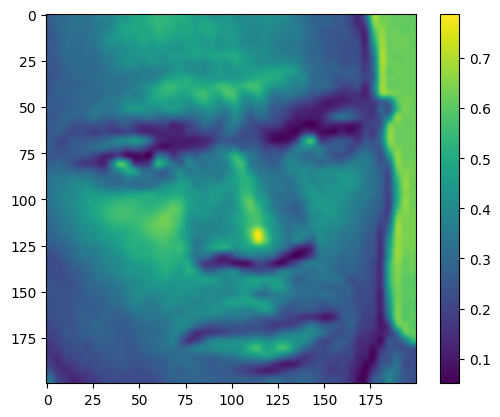

In [29]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [30]:

# train and fit a resnet50 model
resnet50_model = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [31]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
# compile the model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [33]:
n_epoch = 30
# train the model
resnet50_model.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])

Epoch 1/30
572/572 [==============================] - 84s 64ms/step - loss: 1.6427 - categorical_accuracy: 0.3201 - val_loss: 2.9818 - val_categorical_accuracy: 0.3166
Epoch 2/30
572/572 [==============================] - 33s 58ms/step - loss: 1.4597 - categorical_accuracy: 0.4164 - val_loss: 1.5734 - val_categorical_accuracy: 0.4033
Epoch 3/30
572/572 [==============================] - 33s 58ms/step - loss: 1.3078 - categorical_accuracy: 0.4899 - val_loss: 1.7466 - val_categorical_accuracy: 0.4429
Epoch 4/30
572/572 [==============================] - 33s 58ms/step - loss: 1.1491 - categorical_accuracy: 0.5568 - val_loss: 1.1898 - val_categorical_accuracy: 0.5499
Epoch 5/30
572/572 [==============================] - 33s 58ms/step - loss: 1.0166 - categorical_accuracy: 0.6143 - val_loss: 1.3619 - val_categorical_accuracy: 0.5007
Epoch 6/30
572/572 [==============================] - 33s 57ms/step - loss: 0.8926 - categorical_accuracy: 0.6653 - val_loss: 1.6366 - val_categorical_accuracy:

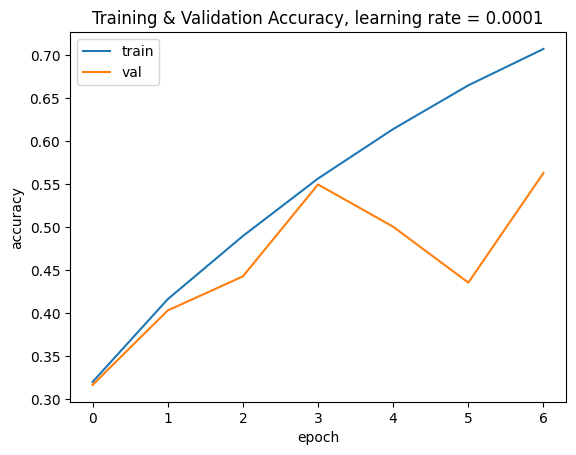

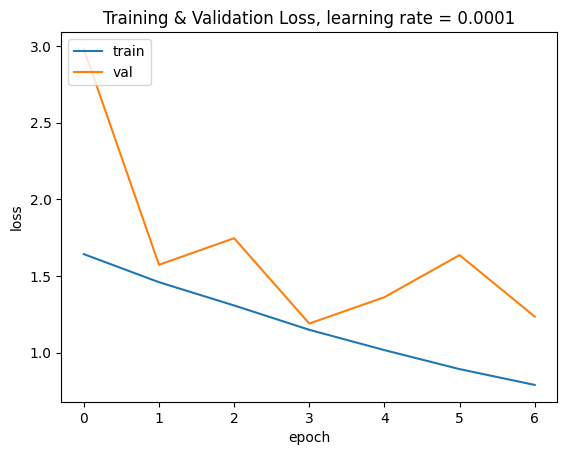

In [34]:
# save the model
resnet50_model.save('resnet50_model.h5')

# plot the accuracy and loss
plt.plot(resnet50_model.history.history['categorical_accuracy'])
plt.plot(resnet50_model.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model.history.history['loss'])
plt.plot(resnet50_model.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
resnet50_model.save('/content/gdrive/My Drive/IDS705/resnet50_model_v2')


Seems with little overfitting issue. Try batch normalisation and drop Out

## Batch Normalisation and Drop Out

In [36]:
# batch normalization and dropout
# train and fit a resnet50 model
resnet50_model_bn = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model_bn.summary()

# add batch normalization and dropout
for layer in resnet50_model_bn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [37]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss  
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor



In [38]:
n_epoch = 30
# train the model
resnet50_model_bn.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])



Epoch 1/30
572/572 [==============================] - 71s 60ms/step - loss: 1.6285 - categorical_accuracy: 0.3302 - val_loss: 2.4996 - val_categorical_accuracy: 0.3171
Epoch 2/30
572/572 [==============================] - 33s 58ms/step - loss: 1.4276 - categorical_accuracy: 0.4297 - val_loss: 1.5379 - val_categorical_accuracy: 0.4221
Epoch 3/30
572/572 [==============================] - 33s 58ms/step - loss: 1.2488 - categorical_accuracy: 0.5173 - val_loss: 1.7264 - val_categorical_accuracy: 0.4158
Epoch 4/30
572/572 [==============================] - 33s 57ms/step - loss: 1.1048 - categorical_accuracy: 0.5748 - val_loss: 1.1725 - val_categorical_accuracy: 0.5422
Epoch 5/30
572/572 [==============================] - 34s 59ms/step - loss: 0.9752 - categorical_accuracy: 0.6265 - val_loss: 1.5670 - val_categorical_accuracy: 0.4074
Epoch 6/30
572/572 [==============================] - 33s 58ms/step - loss: 0.8614 - categorical_accuracy: 0.6721 - val_loss: 1.5592 - val_categorical_accuracy:

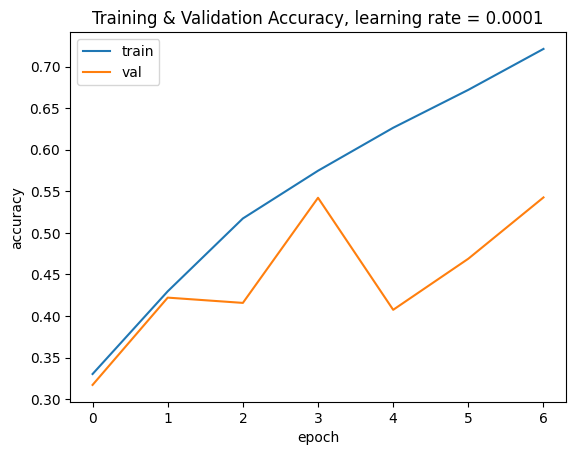

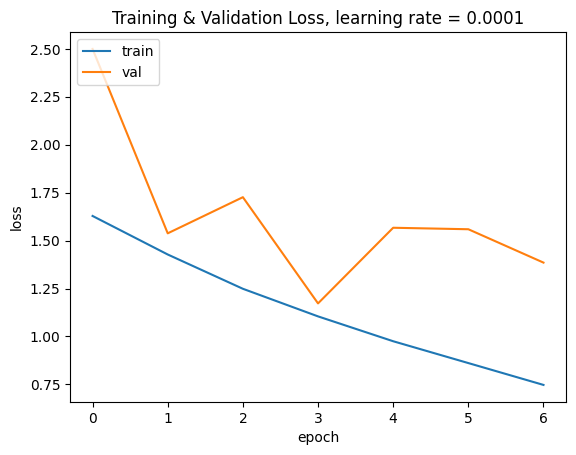

In [39]:
# plot the accuracy and loss
plt.plot(resnet50_model_bn.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bn.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bn.history.history['loss'])
plt.plot(resnet50_model_bn.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
# save the model
resnet50_model_bn.save('/content/gdrive/My Drive/IDS705/resnet50_model_bn_v2')